# Mean Term Frequency Inverse Document Frequency (Mean TF-IDF) and Mean Term Frequency Inverse Sentence Feature (Mean TF-ISF)

## 1. Mean Term Frequency Inverse Document Frequency (Mean TF-IDF)

### Mean TF-IDF

[TF-IDF Site](http://www.tfidf.com/)

Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

The tf-idf weight is composed by two terms:

#### 1. Term Frequency (TF)
This measures how frequently a term occurs in a document. It is the number of times a word appears in a document, divided by the total number of words in that document.
```
TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
```

The term frequency of a word can be normalized by dividing it with the largest corresponding value among all the sentences in the conversation ie. the word with the highest term frequency (TF) in the document

#### 2.  Inverse Document Frequency (IDF)
This measures how important a term is. It is computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears. Certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 
```
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
```


### Example

Consider a document containing `100` words wherein the word cat appears `3` times. The term frequency (i.e., tf) for cat is then `(3 / 100) = 0.03`. Now, assume we have `10 million` documents and the word cat appears in `one thousand` of these. Then, the inverse document frequency (i.e., idf) is calculated as `log(10,000,000 / 1,000) = 4`.

#### 3 TF-IDF
Tf-idf weight is the product of these quantities:  `0.03 * 4 = 0.12.`
```
TF-IDF(t) = TF(t) * IDF(t)
```


In the current use case of conversations, conversations are partitioned by day. Each day conversation is therefore considered a single document. Thus, if we have 27 days of chat messages, we have 27 documents.

**The Mean TF-IDF is calculated as the mean of the tf-idf values of all the words present in the sentence.**


In [77]:
import gzip
import json
import math
import string

from os.path import join

In [38]:
PUNCTUATION_SET = set(string.punctuation)
CHAT_LOG_FILE = join("..", "data_files", "gnue_irc_chat_logs_preprocessed_words_only.txt.gz")
FEATURE_OUTPUT_DIR = join("..", "feature_outputs")
DATA_OUTPUT_DIR = join("..", "data_files")
CHAT_DATE_PARTITIONS_FILE = join("..", "data_files","chat_date_partitions.csv")
WORD_FREQUENCIES = {}
WORD_COUNT = 0
DOCUMENT_WORD_COUNTS = {
    "last_tallied_document": None,
    "total_number_of_documents": 0,
    "word_counts": {} 
}
MAX_WORD_FREQUENCY_PER_DOCUMENT = {}

In [39]:
def strip_leading_and_trailing_punctuation(word):
    return word.strip(string.punctuation) 

In [40]:
def update_word_frequency_and_count(word, current_document_number, document_id=None):
    if not document_id:
        document_id = current_document_number
        
    if word not in WORD_FREQUENCIES:
        WORD_FREQUENCIES[word] = {
            "total_frequency": 1,
            "containing_document_count": 1,
            "last_containing_document": current_document_number,
            "document_frequencies": {
                    document_id: 1
                }
            }
    else:
        WORD_FREQUENCIES[word]["total_frequency"] += 1
        if WORD_FREQUENCIES[word]["last_containing_document"] < current_document_number:
            WORD_FREQUENCIES[word]["containing_document_count"] += 1
            WORD_FREQUENCIES[word]["last_containing_document"] = current_document_number
            WORD_FREQUENCIES[word]["document_frequencies"][document_id] = 1
        elif WORD_FREQUENCIES[word]["last_containing_document"] == current_document_number:
            WORD_FREQUENCIES[word]["document_frequencies"][document_id] += 1
        else:
            raise Exception("Last document is more recent than the current document")
            
    global WORD_COUNT 
    global DOCUMENT_WORD_COUNTS
    global MAX_WORD_FREQUENCY_PER_DOCUMENT
    
    WORD_COUNT += 1
    if DOCUMENT_WORD_COUNTS["last_tallied_document"] != document_id:
        DOCUMENT_WORD_COUNTS["last_tallied_document"] = document_id
        DOCUMENT_WORD_COUNTS["total_number_of_documents"] += 1
        DOCUMENT_WORD_COUNTS["word_counts"][document_id] = 1
        MAX_WORD_FREQUENCY_PER_DOCUMENT[document_id] = (
            WORD_FREQUENCIES[word]["document_frequencies"][document_id], word
        )
    else:
        DOCUMENT_WORD_COUNTS["word_counts"][document_id] += 1
        MAX_WORD_FREQUENCY_PER_DOCUMENT[document_id] = max(
            MAX_WORD_FREQUENCY_PER_DOCUMENT[document_id], 
            (WORD_FREQUENCIES[word]["document_frequencies"][document_id], word)
        )
        

In [41]:
def all_chars_in_word_are_punctuation(word):
    return all(char in PUNCTUATION_SET for char in word)

In [42]:
def get_words_in_sentence(sentence):
    words = []
    for word in sentence.split():
        if not all_chars_in_word_are_punctuation(word):
            word = strip_leading_and_trailing_punctuation(word)
            if ',' in word:
                comma_split_words = word.split(',')
                for word in comma_split_words:
                    if not all_chars_in_word_are_punctuation(word):
                        words.append(word)
            else:
                words.append(word)
    return words
    

In [43]:
def pre_process_sentence(sentence):
    if not sentence:
        print("No words here")
    if type(sentence) is not str:
        try:
            sentence = sentence.decode('utf-8')
        except Exception:
            raise ValueError("Input must be a String or ByteString")
        
    return sentence
    

In [44]:
sentence1 = pre_process_sentence(b"Hello,there. Ju,.,.'',,,,,,,,,st there,checking-in checking-in.")
for word in get_words_in_sentence(sentence1):
    update_word_frequency_and_count(word, 1)

sentence2 = pre_process_sentence(b"Hello everyone else. there, else, else, checking-in,else there,with y'all")
for word in get_words_in_sentence(sentence2):
    update_word_frequency_and_count(word, 2)

expected_word_counts = {
    'last_tallied_document': 2,
    'total_number_of_documents': 2,
    'word_counts': {1: 7, 2: 11}
}

assert DOCUMENT_WORD_COUNTS == expected_word_counts
assert MAX_WORD_FREQUENCY_PER_DOCUMENT == {1: (2, 'there'), 2: (4, 'else')}

In [45]:
DOCUMENT_WORD_COUNTS

{'last_tallied_document': 2,
 'total_number_of_documents': 2,
 'word_counts': {1: 7, 2: 11}}

In [46]:
MAX_WORD_FREQUENCY_PER_DOCUMENT

{1: (2, 'there'), 2: (4, 'else')}

In [47]:
# WORD_FREQUENCIES

In [48]:
WORD_COUNT

18

In [49]:
def generate_document_word_frequencies(
    date_partitions_file, 
    input_file, 
    output_directory, 
    output_file, 
    document_word_counts_file=None
):
    data_output_file = join(output_directory, output_file)
    with open(date_partitions_file, 'r') as chat_partitions, gzip.open(input_file, 'r') as chat_file, open(data_output_file, 'w') as out_file:
        csv_row = chat_partitions.readline()
        total_chats_in_document = int(csv_row.rstrip().split(',')[2])
        document_number = 1
        document_id = csv_row.rstrip().split(',')[1]
        chat_line_count = 0
        total_chat_lines_in_all_documents = 0
        for i, chat_line in enumerate(chat_file):
            sentence = pre_process_sentence(chat_line)
            for word in get_words_in_sentence(sentence):
                update_word_frequency_and_count(word, document_number, document_id)
            chat_line_count += 1
            if chat_line_count >= total_chats_in_document:
                total_chat_lines_in_all_documents += chat_line_count
                csv_row = chat_partitions.readline()
                if not csv_row:
                    print(i)
                    print(total_chat_lines_in_all_documents)
                    assert i+1 == total_chat_lines_in_all_documents
                    assert chat_line_count == total_chats_in_document
                    break
                    
                # reset the chat_line_count
                chat_line_count = 0
                document_number += 1
                document_id = csv_row.rstrip().split(',')[1]
                total_chats_in_document = int(csv_row.rstrip().split(',')[2])
        global WORD_COUNT
        global MAX_WORD_FREQUENCY_PER_DOCUMENT
        
        frequency_data = {
            "total_word_count": WORD_COUNT,
            "max_word_frequency_per_document": MAX_WORD_FREQUENCY_PER_DOCUMENT,
            "word_frequencies": WORD_FREQUENCIES
        }
        print(document_number)
        print(chat_line_count)
        json.dump(frequency_data, out_file)
        if document_word_counts_file:
            with open(join(output_directory, document_word_counts_file), "w") as doc_word_counts_file:
                json.dump(DOCUMENT_WORD_COUNTS, doc_word_counts_file)
        
        

In [50]:
# BE SURE TO RESET WORD_COUNT, WORD_FREQUENCIES and DOCUMENT_WORD_COUNTS BEFORE RUNNING THIS!
WORD_COUNT = 0
WORD_FREQUENCIES = {}
DOCUMENT_WORD_COUNTS = {
    "last_tallied_document": None,
    "total_number_of_documents": 0,
    "word_counts": {}
    
}
MAX_WORD_FREQUENCY_PER_DOCUMENT = {}

date_partitions_file = CHAT_DATE_PARTITIONS_FILE 
input_file = CHAT_LOG_FILE 
output_directory = DATA_OUTPUT_DIR 
output_file = "chat_word_frequencies.json"
document_word_counts_file = "document_word_counts.json"

generate_document_word_frequencies(
    date_partitions_file, 
    input_file, 
    output_directory, 
    output_file, 
    document_word_counts_file
)



659164
659165
1784
337


In [51]:
# WORD_FREQUENCIES

In [52]:
WORD_COUNT

4311154

In [53]:
def get_term_frequency(word_frequency_in_set, total_number_of_terms_in_set):
    return word_frequency_in_set / total_number_of_terms_in_set


In [54]:
def get_normalized_term_frequency(
        word_frequency_in_set, 
        total_number_of_terms_in_set,
        largest_tf_in_set
    ):
    return (word_frequency_in_set / total_number_of_terms_in_set) / largest_tf_in_set


In [55]:
def get_inverse_set_frequency(total_number_of_sets, number_of_sets_with_word):
    return math.log(total_number_of_sets / number_of_sets_with_word, 10)
    

In [56]:
def load_chat_date_word_counts(chat_word_counts_filename):
    with open(chat_word_counts_filename) as word_count_file:
        chat_word_counts = json.loads(word_count_file.readline().rstrip())
    return chat_word_counts
    

In [57]:
load_chat_date_word_counts(join(DATA_OUTPUT_DIR, "document_word_counts.json"))['word_counts']['2003-03-17']

2693

In [58]:
def load_chat_word_frequencies(chat_word_frequencies_filename):
    with open(chat_word_frequencies_filename) as chat_word_frequencies_file:
        chat_word_frequencies = json.loads(chat_word_frequencies_file.readline().rstrip())
    return chat_word_frequencies
    

In [59]:
load_chat_word_frequencies(join(DATA_OUTPUT_DIR, "chat_word_frequencies.json"))["total_word_count"]

4311154

In [60]:
def get_word_tf_idf_or_tf_isf(word_frequency_in_document, 
                    total_number_of_terms_in_document,
                    total_number_of_documents,
                    number_of_documents_with_word
                   ):
    term_frequency = get_term_frequency(word_frequency_in_document, total_number_of_terms_in_document)
    inverse_set_frequency = get_inverse_set_frequency(total_number_of_documents, number_of_documents_with_word)
    return  term_frequency * inverse_set_frequency
    

In [61]:
get_word_tf_idf_or_tf_isf(3, 100, 10000000, 1000)

0.12

In [62]:
def generate_mean_tf_idf(date_partitions_file, 
                         input_file,
                         output_directory, 
                         output_file,
                         chat_date_word_counts, 
                         chat_word_frequencies,
                         word_tf_idfs_output_filename
                        ):
    data_output_file = join(output_directory, output_file)
    with open(
        date_partitions_file, "r") as chat_partitions, gzip.open(
        input_file, "r") as chat_file, open(
        data_output_file, "w") as out_file, open(
        word_tf_idfs_output_filename, "w") as word_tf_idfs_output_file:
        
        csv_row = chat_partitions.readline()
        total_number_of_documents = chat_date_word_counts["total_number_of_documents"]
        document_id = csv_row.rstrip().split(',')[1]
        total_chats_in_document = int(csv_row.rstrip().split(',')[2])
        total_number_of_terms_in_document = chat_date_word_counts["word_counts"][document_id]
        total_chat_lines_in_all_documents = 0
        chat_line_count = 0
        
        for i, sentence in enumerate(chat_file):
            sentence = pre_process_sentence(sentence)
            words_in_sentence = get_words_in_sentence(sentence)
            total_word_tf_idf = 0
            if len(words_in_sentence) < 1:
                word_tf_idfs_output_file.write("0")
            for word in words_in_sentence:
                word_frequency_in_document = chat_word_frequencies["word_frequencies"][word]["document_frequencies"][document_id]
                number_of_documents_with_word = chat_word_frequencies["word_frequencies"][word]["containing_document_count"]
                word_tf_idf = get_word_tf_idf_or_tf_isf(
                    word_frequency_in_document, 
                    total_number_of_terms_in_document,
                    total_number_of_documents,
                    number_of_documents_with_word
                )
                word_tf_idfs_output_file.write("{} ".format(word_tf_idf))
                total_word_tf_idf += word_tf_idf
            if total_word_tf_idf:
                mean_tf_idf = total_word_tf_idf / len(words_in_sentence)
            else:
                mean_tf_idf = 0
            out_file.write("{}\n".format(mean_tf_idf))
            word_tf_idfs_output_file.write("\n")
            
            # if i >= 20:
            #     break
            
            chat_line_count += 1
            if chat_line_count >= total_chats_in_document:
                total_chat_lines_in_all_documents += chat_line_count
                csv_row = chat_partitions.readline()
                if not csv_row:
                    print(i)
                    print(total_chat_lines_in_all_documents)
                    assert i+1 == total_chat_lines_in_all_documents
                    assert chat_line_count == total_chats_in_document
                    break 
                    
                # Reset values and move on to the next document
                chat_line_count = 0
                document_id = csv_row.rstrip().split(',')[1]
                total_chats_in_document = int(csv_row.rstrip().split(',')[2])

    

In [63]:
chat_date_word_counts = load_chat_date_word_counts(join(DATA_OUTPUT_DIR,"document_word_counts.json"))
chat_word_frequencies = load_chat_word_frequencies(join(DATA_OUTPUT_DIR, "chat_word_frequencies.json"))
word_tf_idfs_output_filename = join(DATA_OUTPUT_DIR, "word_tf_idfs.txt")
generate_mean_tf_idf(
    CHAT_DATE_PARTITIONS_FILE, 
    CHAT_LOG_FILE, 
    FEATURE_OUTPUT_DIR,  
    "chats_mean_tf_idf.txt",
    chat_date_word_counts, 
    chat_word_frequencies,
    word_tf_idfs_output_filename
)

659164
659165


In [64]:
def normalize_mean_tf_idf(mean_tf_idf_file, output_directory, normalized_output_file):
    with open(mean_tf_idf_file) as tf_idf_file, \
        open(join(output_directory, normalized_output_file), "w") as output_file:
        max_tf_idf = float('-inf')
        for tf_idf in tf_idf_file:
            max_tf_idf = max(max_tf_idf, float(tf_idf.strip()))
            
        tf_idf_file.seek(0) # Back to the beginning of the file
        for tf_idf in tf_idf_file:
            output_file.write("{}\n".format(float(tf_idf.strip())/max_tf_idf))
    

In [65]:
output_directory = FEATURE_OUTPUT_DIR
mean_tf_idf_file = join(output_directory, "chats_mean_tf_idf.txt")
normalized_output_file = "normalized_chats_mean_tf_idf.txt"
normalize_mean_tf_idf(
    mean_tf_idf_file, 
    output_directory, 
    normalized_output_file
)

## 2. Mean Term Frequency Inverse Sentence Feature (Mean TF-ISF)
Citation: [A Recursive TF-ISF Based Sentence Retrieval Method with
Local Context ](https://pdfs.semanticscholar.org/8084/1022243b8f09703ebd0fffa97bacd5e48a06.pdf)

Sentence retrieval is the task of finding relevant sentences from a document base in response to a query.

The vector space model for sentence retrieval uses the term frequency - **Inverse Sentence Frequency** method **(TF-ISF)** which is analogous to the traditional term frequency – **Inverse Document Frequency** method **(TF-IDF)** used for document retrieval. When it comes to the language model approach for sentence retrieval at first it was implemented as a trivial adaptation from document retrieval to sentence retrieval, with sentences treated as documents.

This feature also captures the frequency but takes into consideration only one conversation at a time. The frequency of a word is characterized as:
```
Term Frequency * Inverse Sentence Frequency
```

This feature is calculated as the mean value of the tf-isf of all the words present in the sentence. This value can be normalized by dividing it with the largest corresponding value among all the words in the sentence.

If `SF(t, d)` represents the sentence frequency of a term `t` in document `d`, and `Sd`, the number of
sentences in document `d`, then the inverse sentence frequency, `isf(t, d)`, is given by:
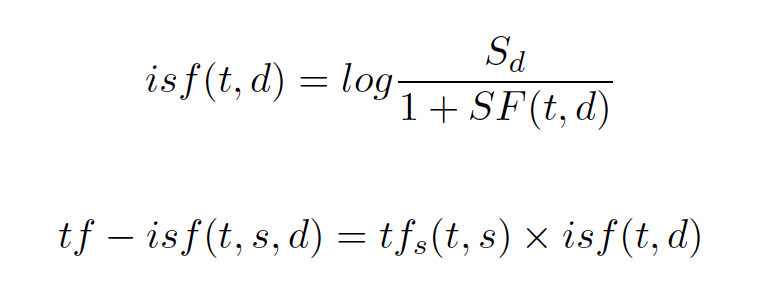


In [66]:
def get_word_frequecies_in_sentence(sentence):
    sentence = pre_process_sentence(sentence)
    sentence_word_frequencies = {}
    words_in_sentence = get_words_in_sentence(sentence)
    for word in words_in_sentence:
        if word in sentence_word_frequencies:
            sentence_word_frequencies[word] += 1
        else:
            sentence_word_frequencies[word] = 1
        
    return sentence_word_frequencies, len(words_in_sentence)
        

In [67]:
sentence3 = "Testing, the word, frequencies ,,, in this. sentence. word"
word_frequencies, sentence_length = get_word_frequecies_in_sentence(sentence3)
assert word_frequencies == {
    'Testing': 1,
    'the': 1,
    'word': 2,
    'frequencies': 1,
    'in': 1,
    'this': 1,
    'sentence': 1
}
assert sentence_length == 8
word_frequencies


{'Testing': 1,
 'the': 1,
 'word': 2,
 'frequencies': 1,
 'in': 1,
 'this': 1,
 'sentence': 1}

In [68]:
## GET RID OF THIS. NOT BEING USED

# def get_mean_sentence_term_frequency(
#     sentence, 
#     normalized_term_frequency=False, 
#     max_mean_sentence_term_frequency=None
# ):
#     word_frequncies_in_sentence, sentence_length = get_word_frequecies_in_sentence(sentence)
#     word_frequency_values = word_frequncies_in_sentence.values()
#     if normalized_term_frequency:
#         if not max_mean_sentence_term_frequency:
#             raise ValueError("Max mean sentence TF must be provided to obtain normalized Mean Sentence TF")
#         sentence_term_frequencies = [
#             get_normalized_term_frequency(
#                 frequency, 
#                 sentence_length, 
#                 max_mean_sentence_term_frequency
#             ) 
#             for frequency in word_frequency_values
#         ]
#     else:
#         sentence_term_frequencies = [
#             get_term_frequency(frequency, sentence_length) for frequency in word_frequency_values]
#     mean_sentence_term_frequency =  sum(sentence_term_frequencies) / sentence_length
#     return mean_sentence_term_frequency

In [69]:
# mean_sentence_term_frequency = get_mean_sentence_term_frequency(sentence3)
# normalized_mean_sentence_term_frequency = get_mean_sentence_term_frequency(sentence3, True, 0.34)
# print(normalized_mean_sentence_term_frequency)
# assert mean_sentence_term_frequency == 0.125
# assert normalized_mean_sentence_term_frequency == 0.3676470588235294
# mean_sentence_term_frequency

In [70]:
def generate_sentence_word_frequencies(date_partitions_file, input_file, output_directory, output_file):
    data_output_file = join(output_directory, output_file)
    SENTENCE_WORD_FREQUENCIES = {}
    with open(date_partitions_file, 'r') as chat_partitions, gzip.open(input_file, 'r') as chat_file, open(data_output_file, 'w') as out_file:
        csv_row = chat_partitions.readline()
        total_sentences_in_document = int(csv_row.rstrip().split(',')[2])
        document_number = 1
        document_id = csv_row.rstrip().split(',')[1]
        SENTENCE_WORD_FREQUENCIES[document_id] = {}
        sentence_line_count = 0
        total_chat_lines_in_all_documents = 0
        for i, sentence in enumerate(chat_file):
            sentence = pre_process_sentence(sentence)
            for word in get_words_in_sentence(sentence):
                if document_id not in SENTENCE_WORD_FREQUENCIES:
                    SENTENCE_WORD_FREQUENCIES[document_id] = {}
                if word in SENTENCE_WORD_FREQUENCIES[document_id]:
                    if sentence_line_count > SENTENCE_WORD_FREQUENCIES[document_id][word]["last_containing_sentence"]:
                        SENTENCE_WORD_FREQUENCIES[document_id][word]["last_containing_sentence"] = sentence_line_count + 1
                        SENTENCE_WORD_FREQUENCIES[document_id][word]["occurence_in_sentences"] += 1
                else:
                    SENTENCE_WORD_FREQUENCIES[document_id][word] = {
                        "last_containing_sentence": sentence_line_count + 1,
                        "occurence_in_sentences": 1
                    }

            sentence_line_count += 1
            
            # if sentence_line_count >= 20:
            #     break
            if sentence_line_count >= total_sentences_in_document:
                total_chat_lines_in_all_documents += sentence_line_count
                csv_row = chat_partitions.readline()
                if not csv_row:
                    print(i)
                    print(total_chat_lines_in_all_documents)
                    assert i+1 == total_chat_lines_in_all_documents
                    assert sentence_line_count == total_sentences_in_document
                    break
                    
                # reset the sentence_line_count
                sentence_line_count = 0
                document_number += 1
                document_id = csv_row.rstrip().split(',')[1]
                total_sentences_in_document = int(csv_row.rstrip().split(',')[2])
        
        print(document_number)
        print(sentence_line_count)
        json.dump(SENTENCE_WORD_FREQUENCIES, out_file)
        

In [71]:
generate_sentence_word_frequencies(
    CHAT_DATE_PARTITIONS_FILE, 
    CHAT_LOG_FILE, 
    DATA_OUTPUT_DIR, 
    "sentence_word_frequencies.json"
)

659164
659165
1784
337


In [72]:
def load_sentence_word_frequencies(sentence_word_frequencies_filename):
    with open(sentence_word_frequencies_filename) as sentence_word_frequencies_file:
        sentence_word_frequencies = json.loads(sentence_word_frequencies_file.readline().rstrip())
    return sentence_word_frequencies

In [73]:
filename = join(DATA_OUTPUT_DIR, "sentence_word_frequencies.json")
load_sentence_word_frequencies(filename)['2001-08-06']['diff']

{'last_containing_sentence': 2, 'occurence_in_sentences': 1}

In [74]:
def generate_mean_tf_isf(date_partitions_file, 
                         input_file,
                         output_directory, 
                         output_file, 
                         sentence_word_frequencies
                        ):
    data_output_file = join(output_directory, output_file)
    with open(date_partitions_file, 'r') as chat_partitions, gzip.open(input_file, 'r') as chat_file, open(data_output_file, 'w') as out_file:
        csv_row = chat_partitions.readline()
        total_number_of_sentences = int(csv_row.rstrip().split(',')[2])
        document_id = csv_row.rstrip().split(',')[1]
        # total_number_of_terms_in_document = chat_date_word_counts["word_counts"][document_id]
        total_chat_lines_in_all_documents = 0
        chat_line_count = 0
        
        for i, sentence in enumerate(chat_file):
            # mean_sentence_term_frequency = get_mean_sentence_term_frequency(sentence)
            word_frequencies_in_sentence, total_number_of_terms_in_sentence = get_word_frequecies_in_sentence(sentence)
            total_word_tf_isf = 0
            for word, word_frequency_in_sentence in word_frequencies_in_sentence.items():
                # word_frequency_in_sentence = word_frequencies_in_sentence
                # get_inverse_set_frequency(total_number_of_sentences, frequency)
                number_of_sentences_with_word = sentence_word_frequencies[document_id][word]["occurence_in_sentences"]
                word_tf_isf = get_word_tf_idf_or_tf_isf(
                    word_frequency_in_sentence, 
                    total_number_of_terms_in_sentence,
                    total_number_of_sentences,
                    number_of_sentences_with_word
                )
                total_word_tf_isf += word_tf_isf
            if total_word_tf_isf:
                mean_tf_isf = total_word_tf_isf / total_number_of_terms_in_sentence
            else:
                mean_tf_isf = 0
            out_file.write("{}\n".format(mean_tf_isf))
            
            # if i >= 20:
            #    break
            
            chat_line_count += 1
            if chat_line_count >= total_number_of_sentences:
                total_chat_lines_in_all_documents += chat_line_count
                csv_row = chat_partitions.readline()
                if not csv_row:
                    print(i)
                    print(total_chat_lines_in_all_documents)
                    assert i+1 == total_chat_lines_in_all_documents
                    assert chat_line_count == total_number_of_sentences
                    break 
                    
                # Reset values and move on to the next document
                chat_line_count = 0
                document_id = csv_row.rstrip().split(',')[1]
                total_number_of_sentences = int(csv_row.rstrip().split(',')[2])


In [75]:
filename = join(DATA_OUTPUT_DIR, "sentence_word_frequencies.json")
sentence_word_frequencies = load_sentence_word_frequencies(filename)
generate_mean_tf_isf(
    CHAT_DATE_PARTITIONS_FILE, 
    CHAT_LOG_FILE,
    FEATURE_OUTPUT_DIR, 
    "chats_mean_tf_isf.txt",
    sentence_word_frequencies
)

659164
659165


In [76]:
output_directory = FEATURE_OUTPUT_DIR
mean_tf_isf_file = join(output_directory, "chats_mean_tf_isf.txt")
normalized_output_file = "normalized_chats_mean_tf_isf.txt"
normalize_mean_tf_idf(mean_tf_isf_file, output_directory, normalized_output_file)